In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import papermill as pm
import json
import matplotlib.pyplot as plt
import os
import uuid
from db import Result
import ast
import math
from vis.visualization import visualize_cam, visualize_saliency, overlay
from vis.utils.utils import load_img, normalize, find_layer_idx


pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.


In [3]:
from evaluate import load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, plot_multiple_grad_cam, plot_precision_recall

In [4]:
from data import data
from run import characterize_data
from config import config

In [5]:
UUID = "a529a65d-ff07-417b-b2ee-a141e6a68bc8"

#run2: based on highest validation accuracy
#t1: ed73b8f5-bcb9-4754-a08e-70ea533cfa21
#t1_post: a529a65d-ff07-417b-b2ee-a141e6a68bc8
#t2: 45da0510-772c-4cda-a80a-355126338bf1
#features: 2ebdc082-43b9-41db-8950-d631688cc32c



SELECTIONS = "None"
TSNE_PERPLEXITY = 20

In [6]:
# Parameters
#UUID = "b0fb56eb-f2fa-4a5a-bd76-297ec64a371e"
#SELECTIONS = "None"
#TSNE_PERPLEXITY = "None"


In [7]:
SELECTIONS = eval(SELECTIONS)

In [8]:
result = Result.query.filter(Result.uuid == UUID).first()

In [9]:
print("input form:", result.input_form)

input form: t1_post


In [10]:
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, UUID, result.model)

In [11]:
train, validation, test = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

100%|██████████| 34/34 [00:18<00:00,  1.84it/s]


In [12]:
print("training N:", len(train))
print("validation N:", len(validation))
print("test N:", len(test))

training N: 234
validation N: 67
test N: 34


In [13]:
class_inv = {v: k for k, v in train.class_indices.items()}
print("training {}:".format(class_inv[1]), sum(train.classes))
print("validation {}:".format(class_inv[1]), sum(validation.classes))
print("test {}:".format(class_inv[1]), sum(test.classes))

training malignant: 40
validation malignant: 12
test malignant: 6


In [14]:
model = load(MODEL)

In [15]:
model

# Train

In [16]:
results = get_results(model, train)

In [17]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(train)
pm.record("train_labels", list(labels))
pm.record("train_probabilities", list(probabilities))
pm.record("train_predictions", list(predictions))

/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  after removing the cwd from sys.path.


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  


## Train statistics

In [18]:
loss, accuracy = calculate_accuracy_loss(model, train)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=train.class_indices)

Accuracy: 0.9572649567555158
Loss: 2.8011404754769087


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.957,194,30,10,0,1.000,0.750,0.951,1.000,0.250,0.000,0.049,0.875,0.866
malignant,0.957,30,194,0,10,0.750,1.000,1.000,0.951,0.000,0.250,0.000,0.875,0.866


## Train confusion matrix

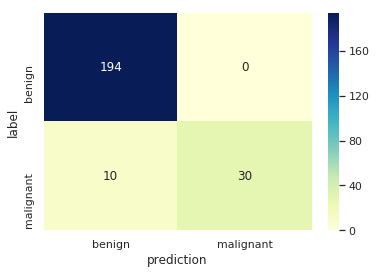

In [19]:
fig = plot_confusion_matrix(train, results)
fig.savefig("figures/{}-{}-train-confusion-matrix.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Train ROC curve

No handles with labels found to put in legend.


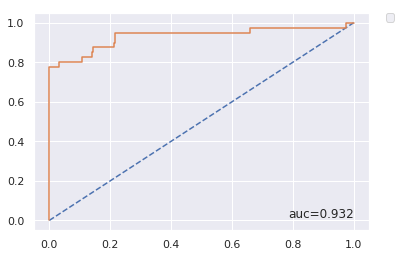

In [20]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-train-ROC-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Train precision-recall curve

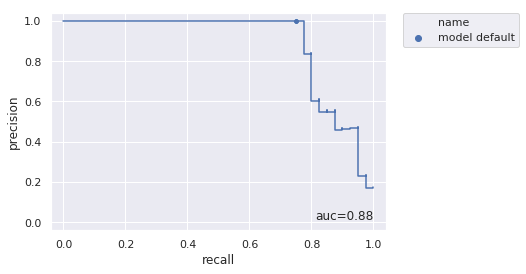

In [21]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-train-precisionrecall-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

# Validation

In [22]:
results = get_results(model, validation)

In [23]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)
pm.record("validation_labels", list(labels))
pm.record("validation_probabilities", list(probabilities))
pm.record("validation_predictions", list(predictions))

/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  after removing the cwd from sys.path.


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  


## Validation statistics

In [24]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

Accuracy: 0.9402985083523081
Loss: 2.9328582962947105


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.940,55,8,4,0,1.000,0.667,0.932,1.000,0.333,0.000,0.068,0.833,0.816
malignant,0.940,8,55,0,4,0.667,1.000,1.000,0.932,0.000,0.333,0.000,0.833,0.816


## Validation confusion matrix

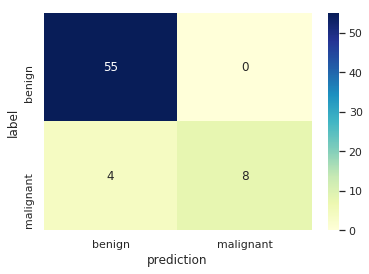

In [25]:
fig = plot_confusion_matrix(validation, results)
fig.savefig("figures/{}-{}-validation-confusion-matrix.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Validation ROC curve

No handles with labels found to put in legend.


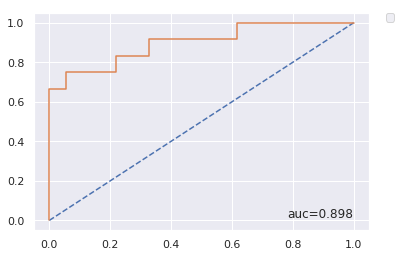

In [26]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-validation-ROC-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Validation precision-recall curve

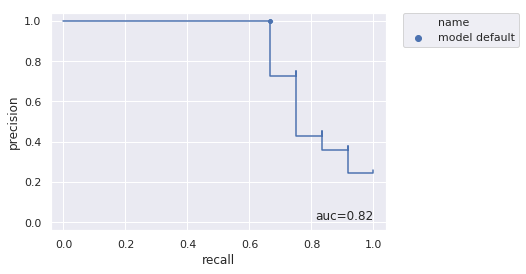

In [27]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-validation-precisionrecall-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

# Test

In [28]:
results = get_results(model, test)

In [29]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(test)
pm.record("test_labels", list(labels))
pm.record("test_probabilities", list(probabilities))
pm.record("test_predictions", list(predictions))

/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  after removing the cwd from sys.path.


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  """


/home/user1/Envs/ovarian-ZJ9fDbrR/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Function record is deprecated and will be removed in verison 1.0.0 (current version 0.19.0). Please see `scrapbook.glue` (nteract-scrapbook) as a replacement for this functionality.
  


## Test statistics

In [30]:
loss, accuracy = calculate_accuracy_loss(model, test)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

Accuracy: 0.9411764705882353
Loss: 2.9356460992027733


,Acc,TP,TN,FP,FN,TPR,TNR,PPV,NPV,FPR,FNR,FDR,AM,GM
benign,0.941,28,4,2,0,1.000,0.667,0.933,1.000,0.333,0.000,0.067,0.833,0.816
malignant,0.941,4,28,0,2,0.667,1.000,1.000,0.933,0.000,0.333,0.000,0.833,0.816


## Test confusion matrix

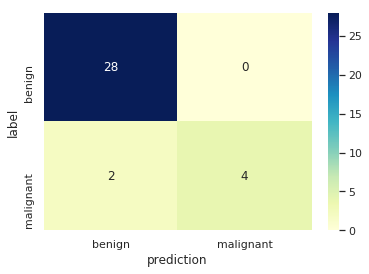

In [31]:
fig = plot_confusion_matrix(test, results)
fig.savefig("figures/{}-{}-test-confusion-matrix.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Test ROC curve

No handles with labels found to put in legend.


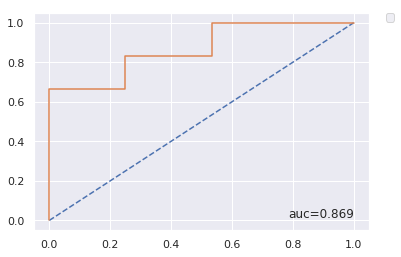

In [32]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-test-ROC-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

## Test precision-recall curve

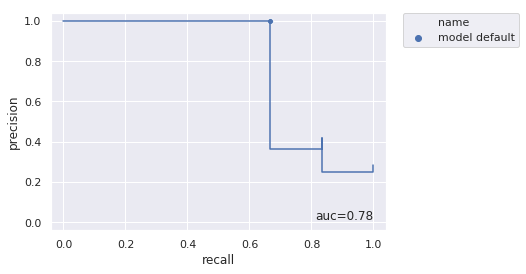

In [33]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-test-precisionrecall-curve.svg".format(result.description, result.input_form), bbox_inches = "tight")

In [34]:
import json
hyperparameters = json.loads(result.hyperparameters)
deep_top = hyperparameters["deep-dense-top"]
grad_cam_layer = "dense_3"
if deep_top: 
    grad_cam_layer = "dense_6"

# TSNE

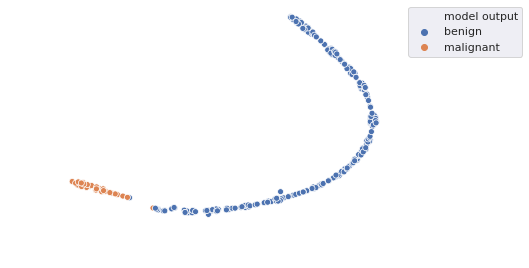

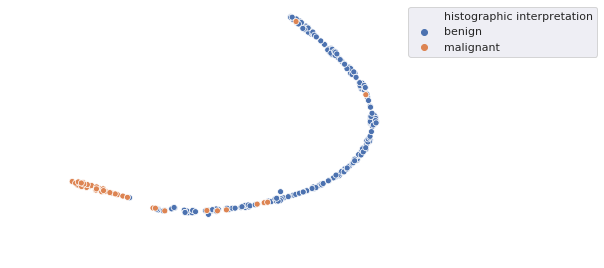

In [35]:
if result.input_form != "features": 
    layer = "dense_1"
    if deep_top: 
        layer = "dense_3"
    tsne_dataset = train
    tsne_dataset.reset()
    fieldnames = ["histographic interpretation"]
    tsne_results = ["malignant" if i else "benign" for i in transform_binary_predictions(get_results(model, tsne_dataset))]
    figs = plot_tsne(
        model, 
        layer, 
        tsne_dataset, 
        [tsne_results, tsne_dataset.labels], 
        fieldnames=["model output", *fieldnames], 
        perplexity=TSNE_PERPLEXITY,
    )
    for i, field in enumerate(["model output", *fieldnames]): 
        figs[i].savefig("figures/{}-{}-{}-tsne.svg".format(result.description, result.input_form, field.replace(" ", "-")), bbox_inches = "tight")
    tsne_dataset.reset()

# Grad Cam

In [36]:
def show_grad_cam_images(images, labels, predictions, names=None, penultimate_layer="res5c_branch2c", layer="dense_3", columns=2, include_label=True):
    filter_idx = [0]
    grad_modifier = None
    backprop_modifier = None
    penultimate_layer_idx = None
    if penultimate_layer:
        penultimate_layer_idx = find_layer_idx(model, penultimate_layer)    
    rows = int(math.ceil(len(images) * 2/columns))
    f, ax = plt.subplots(rows, columns, figsize=(5.5, 3 * rows))    
    ax = ax.flatten()
    for i, image in enumerate(images): 
        grad = visualize_cam(
            model,
            find_layer_idx(model, layer),
            filter_idx,
            normalize(image),
            penultimate_layer_idx=penultimate_layer_idx,
            backprop_modifier=backprop_modifier,
            grad_modifier=grad_modifier)
        if names is not None: 
            ax[2*i].set_title("{}".format(names[i]))
        ax[2*i].imshow(image)
        ax[2*i].axis('off')
        if include_label: 
            ax[2*i+1].set_title("label/pred: {}/{}".format(labels[i], predictions[i]))
        ax[2*i+1].imshow(overlay(grad, image))
        ax[2*i+1].axis('off')
    return f, ax

In [37]:
grad_cam_dataset = validation
grad_cam_dataset.reset()
grad_cam_results = ["malignant" if i else "benign" for i in transform_binary_predictions(get_results(model, grad_cam_dataset))]
if grad_cam_dataset.parameters["t1"]: 
    show_grad_cam_images(grad_cam_dataset.t1, grad_cam_dataset.labels, grad_cam_results, grad_cam_dataset.names, layer=grad_cam_layer)
    plt.show()
if grad_cam_dataset.parameters["t2"]: 
    show_grad_cam_images(grad_cam_dataset.t2, grad_cam_dataset.labels, grad_cam_results, grad_cam_dataset.names, penultimate_layer="res5c_branch2c_t2", layer=grad_cam_layer)
    plt.show()

In [38]:
grad_cam_dataset = validation
grad_cam_dataset.reset()
grad_cam_results = ["malignant" if i else "benign" for i in transform_binary_predictions(get_results(model, grad_cam_dataset))]
inv_indices = {v: k for k, v in grad_cam_dataset.class_indices.items()}

if SELECTIONS == None: 
    SELECTIONS = dict()

if grad_cam_dataset.parameters["t1"]: 
    for k, v in SELECTIONS.items():
        images = grad_cam_dataset.t1
        selected_images = list()
        selected_labels = list()
        selected_results = list()
        for i, name in enumerate(grad_cam_dataset.names): 
            if name in v: 
                selected_images.append(images[i])
                selected_labels.append(grad_cam_dataset.labels[i])
                selected_results.append(grad_cam_results[i])            
        fig, ax = show_grad_cam_images(selected_images, selected_labels, selected_results, include_label=False, names=None, layer=grad_cam_layer)
        title = fig.suptitle("Label: {} | Prediction: {}".format(k[0], k[1]))
        fig.savefig("figures/{}-{}-grad-cam-{}-{}.svg".format(result.description, result.input_form, k[0], k[1]), bbox_inches = "tight", bbox_extra_artists=[title])                
        fig.show()

if grad_cam_dataset.parameters["t2"]: 
    for k, v in SELECTIONS.items():
        images = grad_cam_dataset.t2
        selected_images = list()
        selected_labels = list()
        selected_results = list()
        for i, name in enumerate(grad_cam_dataset.names): 
            if name in v: 
                selected_images.append(images[i])
                selected_labels.append(grad_cam_dataset.labels[i])
                selected_results.append(grad_cam_results[i])
        fig, ax = show_grad_cam_images(selected_images, selected_labels, selected_results, names=None, penultimate_layer="res5c_branch2c_t2",include_label=False, layer=grad_cam_layer)
        title = fig.suptitle("Label: {} | Prediction: {}".format(k[0], k[1]))
        fig.savefig("figures/{}-{}-grad-cam-{}-{}.svg".format(result.description, result.input_form, k[0], k[1]), bbox_inches = "tight", bbox_extra_artists=[title])        
        fig.show()

In [39]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')